In [8]:
import os
from pySMOKEPostProcessor import PostProcessor
from pySMOKEPostProcessor import FluxByClass
from pySMOKEPostProcessor import plot_heatmap
from pySMOKEPostProcessor import save_fig

# Rate Of Production Analysis by Reaction Class
The rate of production analysis can be organized according to reaction classes. Different levels of classification are available:

> * `Class type`: defined by the user in **rxn_class_groups.txt** text file (see data/Classes). Broad classification (e.g., bond-fission, H-abstraction, growth)
> * `Reaction type`: reaction channels belonging to a certain class type. These are listed within the class types in the text file. They must also be present in the **kinetics.xml** file (hard coded)
> * `Species type`: type of species that defines the functional group participating to the reaction (e.g., A1-M is the aromatic ring in its molecular form, A1-R is a phenyl-like radical)
> * `Bimolecular type`: classification according to unimolecular/bimolecular reaction type, accounting for the nature of the reacting species (M, R, RSR: molecule, radical, resonance-stabilized radical). This classification does not require specific input.

Required input for the different steps

* `FluxByClass`: class that handles the classification of reactions. Input arguments are:
    > * `kin_xml_fld` (*str*): path to the folder containing the files relative to the kinetic mechanism named directly, after the pre-processing by OpenSMOKE++: **kinetics.xml** and **reaction_names.xml**.
    > * `class_groups` (*str*): path to file **rxn_class_groups.txt** (or other name) with the groups.
    
* `FluxByClass.process_flux`: assigns the reaction flux according to the user requests. for now, only global flux analysis is available. This function calls the pySMOKEpostprocessor.RateOfProductionAnalysis. Input arguments are:
    > * `species_list` (*list*): list of species to perform ROPA for; accepts strings or dictionaries if you want to sum up fluxes for more than one species. Example {'PAH': ['C10H8', 'INDENE' ,'BIPHENYL']} sums the flux of these 3 species and names it "PAH" in the heatmap
    > * `simul_fld` (*str*): path to the folder containing OpenSMOKE++ output simulation files. **Output.xml** is required.
    > * `ropa_type` (*str*): type of ROPA (global is the only available option for now).
    > * `n_of_rxns` (*int*, default: 100): number of reactions to be included in the flux analysis (from those with the highest flux).
    

* `FluxByClass.sort_and_filter`: organizes classes for each species flux by reaction class and sums fluxes in the same class. filters classes (i.e., reduces the set of reactions considered) by user-defined criteria. requires:
    > * `sortlist` (*list(str)*): criteria to be considered hierarchically for reaction flux sorting. allowed strings: **classtype,speciestype,reactiontype,bimoltype**. For instance, ['speciestype','reactiontype'] groups reactions according to species type, and within that set the reactions are grouped according to reaction type.
    > * `filter_dct` (*dict: list(str)*, default: {}):filtering for set of classes. dictionary keys correspond to criteria allowed for sortlist, and the value is a list of strings that have to be contained in the class filtered. For instance, {'classtype':['ADD','ABS']} filters all reactions whose classtype includes either 'ADD' or 'ABS' (i.e., abstractions and addition reactions).
    > * `threshold` (*float*, default: 1e-3): minimum relative flux to be considered in the classification. Reactions with smaller flux will be removed.
    > * `weigheach` (*bool*, default: True): weigh the flux of each species according to the maximum absolute flux.

* `plot_heatmap`: plots heat maps according to the dataframe provided
    > * `sortdf` (*pandas dataframe*): flux according to species (column) and reaction class (row)
    > * `symmetricaxis` (*bool*, default: False): decide how to scale the colorbar for plotting. True: 0 is in the middle, and the axis is symmetric with respect to minimum and maximum values. False: axis shifted according to where the 0 is.

In [2]:
kin_xml_fld = os.path.join('..', 'data', 'Classes', 'kinetics')
class_groups_fld = os.path.join('..', 'data', 'Classes', 'rxn_class_groups.txt')
plt_fld = os.path.join('..', 'Figures')
simul_flds ={'example-c6h6' : os.path.join('..', 'data', 'Classes', 'simul', 'Output')}

### Example 0: 
reactions are classified according to reactiontype; all parameters set to default

C6H6 {'coefficients': [-1.8758973947006122e-05, -9.803970996472632e-06, -3.0586660202252125e-06, -3.0586660202252125e-06, -2.047664782595196e-06, -1.5685744417504507e-06, -8.67890353630506e-07, 6.020382722700615e-07, -3.454191705232936e-07, -2.3301113190577174e-07, 2.0448247095908747e-07, -1.7969318717416984e-07, 1.0234326907520016e-07, 7.61756394301114e-08, -6.596118799130792e-08, 6.096463442041709e-08, -5.993054661114705e-08, -5.9247265291349366e-08, -4.9585482212822387e-08, -4.9085938920188483e-08, 3.3128243043579903e-08, -2.2458853664532422e-08, -1.763058618434403e-08, 1.3904780194188704e-08, 1.3335552157012819e-08, -7.8996353721799e-09, -7.308090212710714e-09, -6.4829392115791485e-09, 6.481681968264117e-09, -5.343895486092958e-09, -4.9415630825200485e-09, 3.5869976328960554e-09, 3.406097442350776e-09, 3.2525905084763245e-09, 3.22123214719798e-09, 3.169653373635894e-09, 3.1250783647719907e-09, 3.1232644509386395e-09, 3.067472946844691e-09, 2.4076464572956343e-09, -2.385488298859671

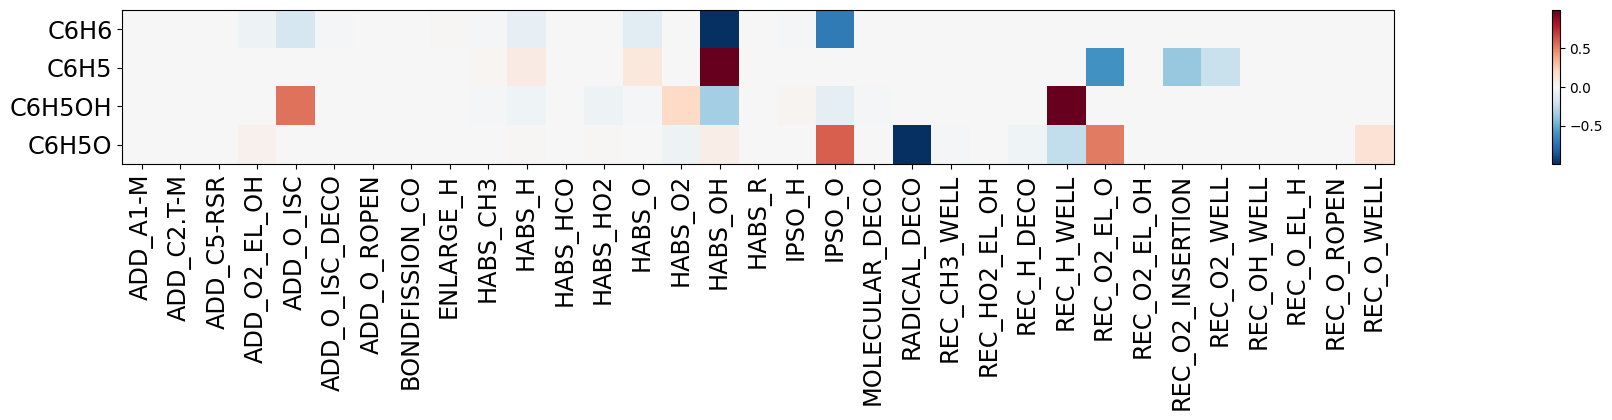

In [13]:
# additional type of classification: filter addition and abstraction reactions
species_list =['C6H6','C6H5','C6H5OH', 'C6H5O']
sortlist = ['reactiontype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) sum if both apply and sort by this criteria
# specify ropa options
ropa_type = 'global'

# extract mech
for simul_name, simul_fld in simul_flds.items():
    pp = PostProcessor(kin_xml_fld, simul_fld)
    # assign class
    fluxbyclass = FluxByClass(pp.km, class_groups_fld)

    # ROPA for each species - if species_list contains dictionary, extract flux for each
    if isinstance(species_list[0], dict):
        flat_species_list = sum([list(d.values())[0] for d in species_list], [])
    else:
        flat_species_list = species_list
        
    tot_rop_dct = dict.fromkeys(flat_species_list)
    for sp in flat_species_list:
        tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                    ropa_type,
                                                    number_of_reactions=100)

    # assign flux and process according to selected criteria
    fluxbyclass.process_flux(species_list, tot_rop_dct)
    sortdf = fluxbyclass.sort_and_filter(sortlist)

    # plot heatmap
    fig = plot_heatmap(sortdf, symmetricaxis = True)
    # save heatmap
    save_fig(fig, plt_fld, sortlist, simul_name)

### Example 1 - global flux analysis by class/species/bimol. types: 
reactions are classified according to classtype, speciestype, ans bimoltype. The threshold to filter the flux is 0.1%.

C6H6 {'coefficients': [-1.8758973947006122e-05, -9.803970996472632e-06, -3.0586660202252125e-06, -3.0586660202252125e-06, -2.047664782595196e-06, -1.5685744417504507e-06, -8.67890353630506e-07, 6.020382722700615e-07, -3.454191705232936e-07, -2.3301113190577174e-07, 2.0448247095908747e-07, -1.7969318717416984e-07, 1.0234326907520016e-07, 7.61756394301114e-08, -6.596118799130792e-08, 6.096463442041709e-08, -5.993054661114705e-08, -5.9247265291349366e-08, -4.9585482212822387e-08, -4.9085938920188483e-08, 3.3128243043579903e-08, -2.2458853664532422e-08, -1.763058618434403e-08, 1.3904780194188704e-08, 1.3335552157012819e-08, -7.8996353721799e-09, -7.308090212710714e-09, -6.4829392115791485e-09, 6.481681968264117e-09, -5.343895486092958e-09, -4.9415630825200485e-09, 3.5869976328960554e-09, 3.406097442350776e-09, 3.2525905084763245e-09, 3.22123214719798e-09, 3.169653373635894e-09, 3.1250783647719907e-09, 3.1232644509386395e-09, 3.067472946844691e-09, 2.4076464572956343e-09, -2.385488298859671

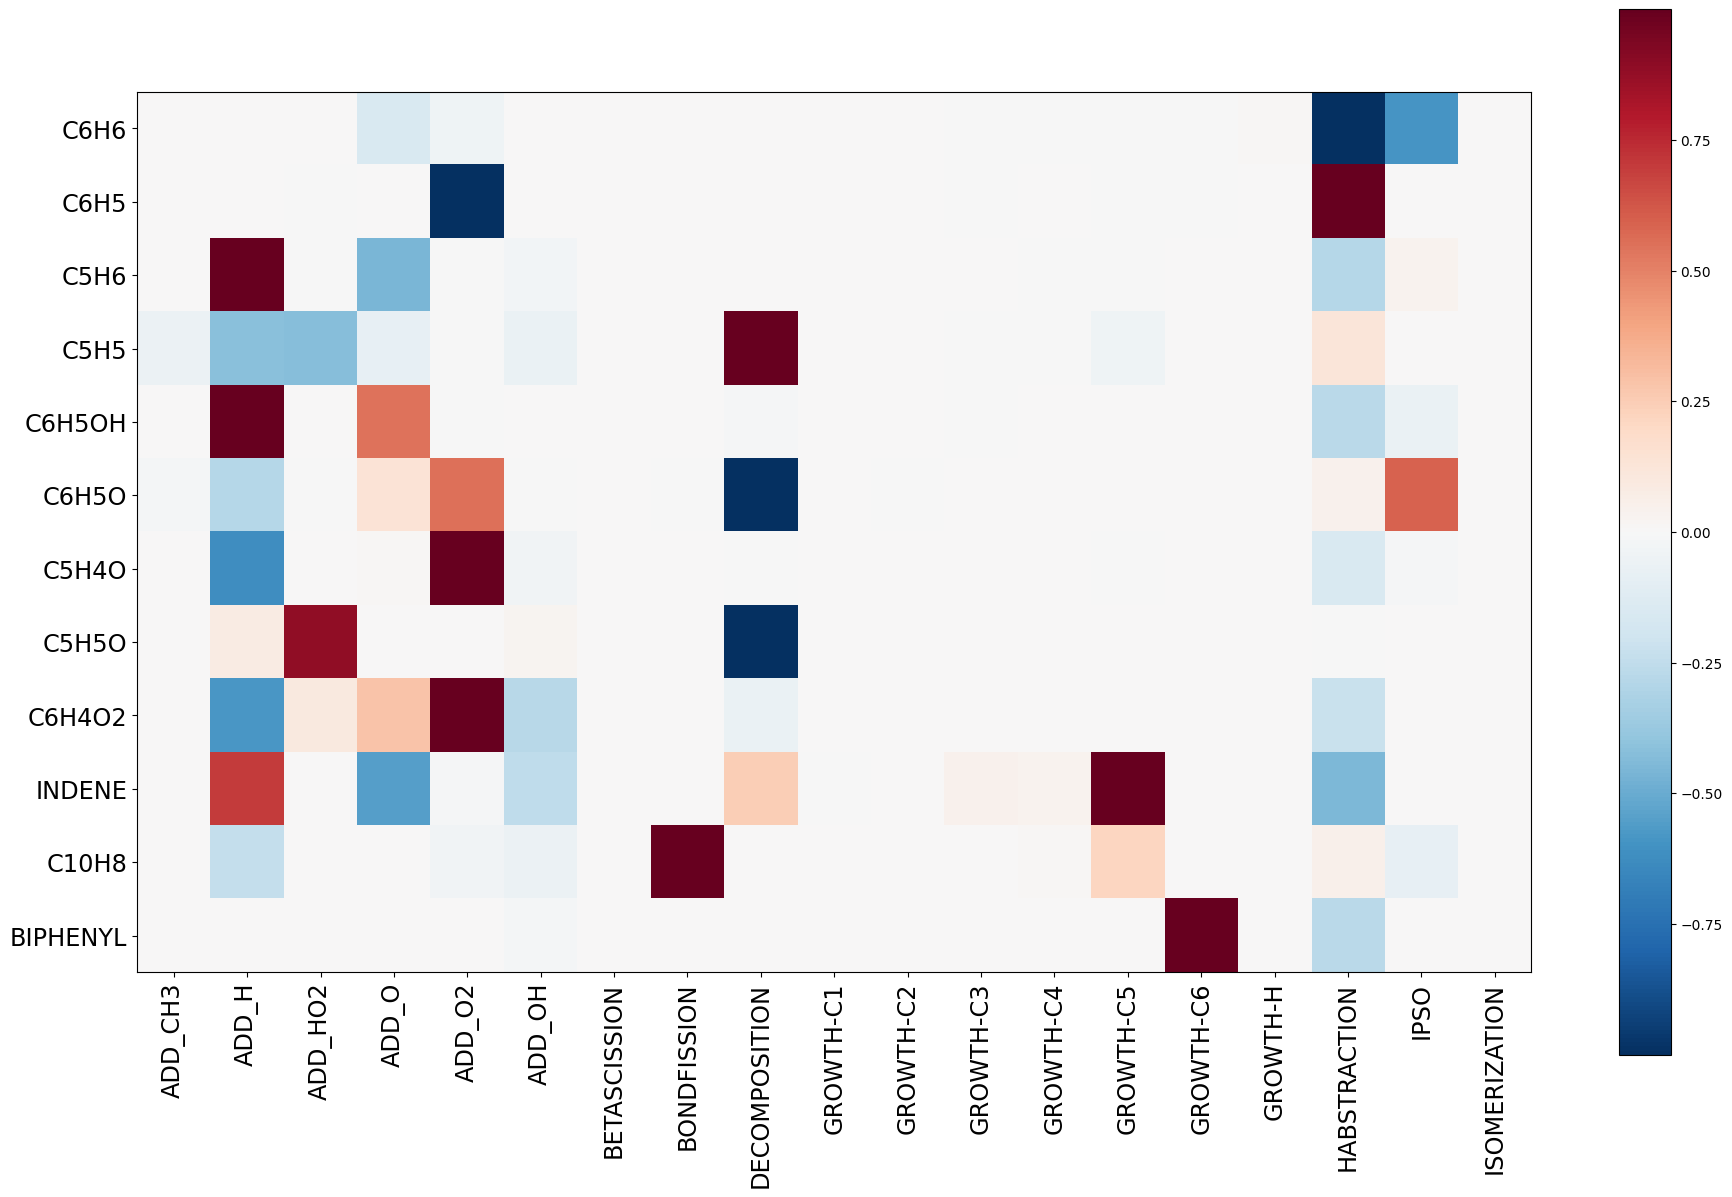

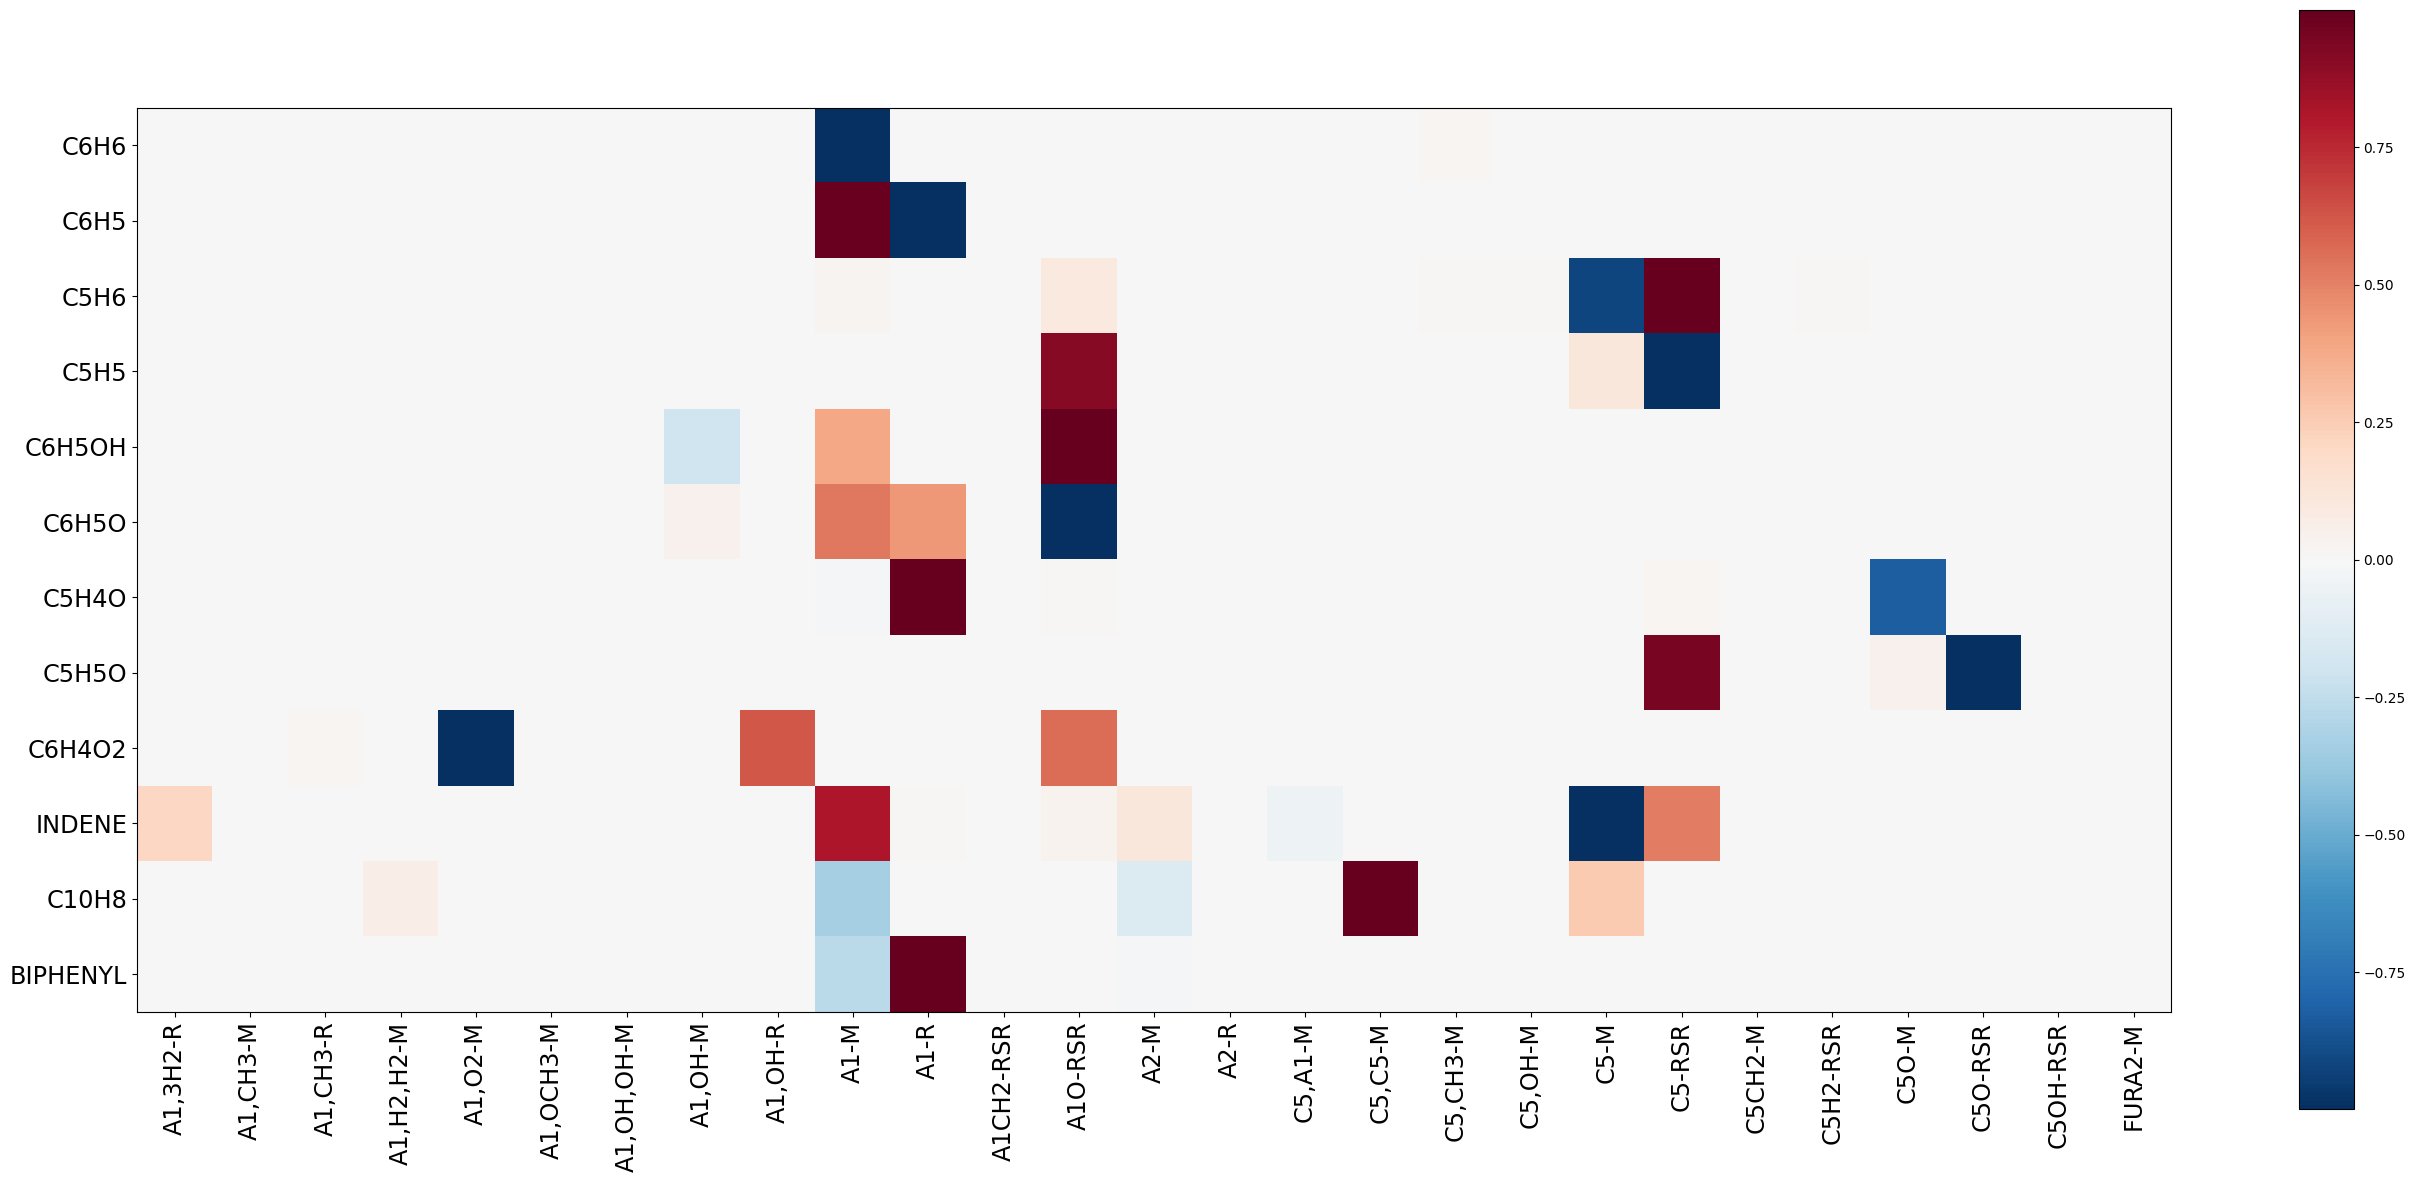

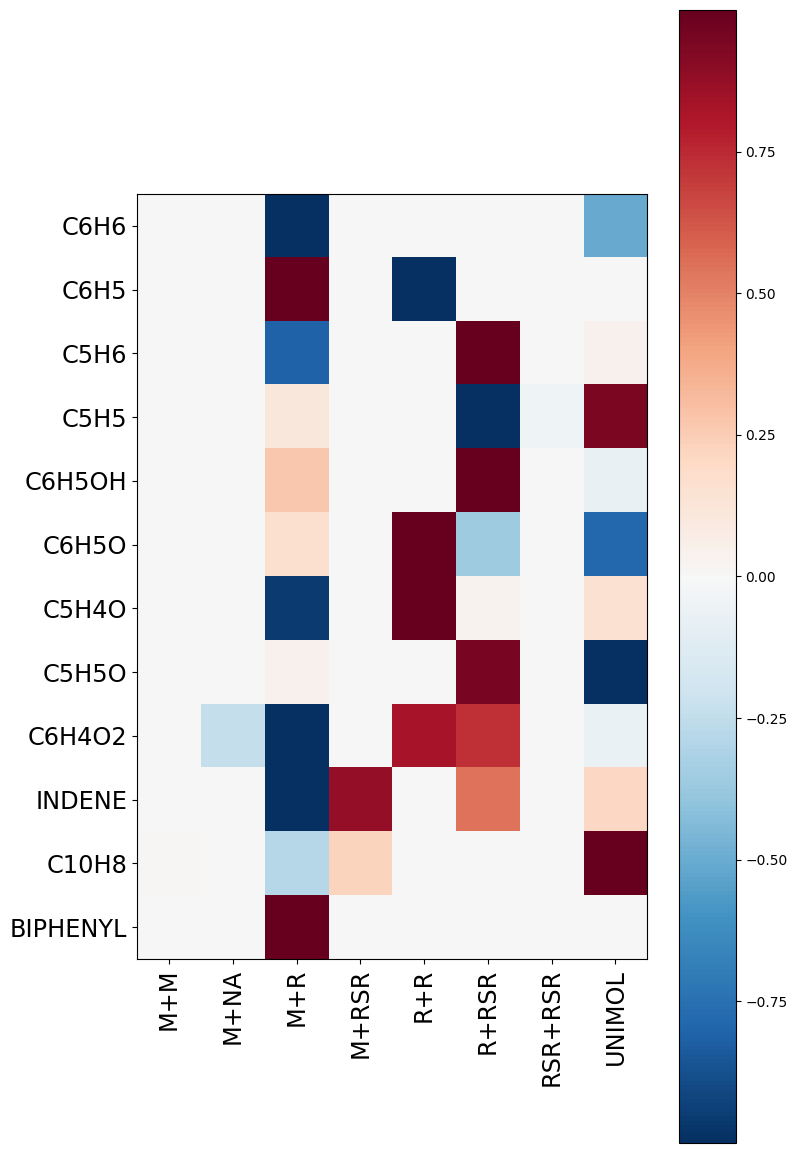

In [15]:
species_list =['C6H6','C6H5','C5H6','C5H5','C6H5OH','C6H5O','C5H4O','C5H5O','C6H4O2','INDENE','C10H8','BIPHENYL']
# filter_dcts = [{},{},{}] # filter is optional  # filter according to selected criteria in name
threshs = [1e-2,1e-2,1e-2] # threshold for minimum flux - default 1e-3
n_of_rxns = 200            # max n of rxns to consider for flux (default: 100)
sortlists = [['classtype'],['speciestype'],['bimoltype']] # classtype, speciestype, reactiontype, 
                                                          # bimoltype (R+R, RSR+RSR, M+M, ETC) 
                                                          # sum if both apply and sort by this criteria

for simul_name, simul_fld in simul_flds.items():
    pp = PostProcessor(kin_xml_fld, simul_fld)
    # assign class
    fluxbyclass = FluxByClass(pp.km, class_groups_fld)

    # ROPA for each species - if species_list contains dictionary, extract flux for each
    if isinstance(species_list[0], dict):
        flat_species_list = sum([list(d.values())[0] for d in species_list], [])
    else:
        flat_species_list = species_list
        
    tot_rop_dct = dict.fromkeys(flat_species_list)
    for sp in flat_species_list:
        tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                    ropa_type='global',
                                                    number_of_reactions=100)
    # prima c'era fluxbyclass qua sopra
    fluxbyclass.process_flux(species_list, tot_rop_dct)
    for i, sortlist in enumerate(sortlists):
        # assign flux and process according to selected criteria
        sortdf = fluxbyclass.sort_and_filter(sortlist)
        # plot heatmap
        fig = plot_heatmap(sortdf, symmetricaxis = True)
        # save heatmap
        save_fig(fig, plt_fld, sortlist, simul_name)

### Example 2 - global flux analysis with hierarchical double classification: 
reactions are now classified hierarchically according to [classtype][bimoltype]. The reactions are filtered such that only additions and abstraction reactions (of additions and abstraction class types) are considered. The threshold to filter the flux is 0.1%.

C6H6 {'coefficients': [-1.8758973947006122e-05, -9.803970996472632e-06, -3.0586660202252125e-06, -3.0586660202252125e-06, -2.047664782595196e-06, -1.5685744417504507e-06, -8.67890353630506e-07, 6.020382722700615e-07, -3.454191705232936e-07, -2.3301113190577174e-07, 2.0448247095908747e-07, -1.7969318717416984e-07, 1.0234326907520016e-07, 7.61756394301114e-08, -6.596118799130792e-08, 6.096463442041709e-08, -5.993054661114705e-08, -5.9247265291349366e-08, -4.9585482212822387e-08, -4.9085938920188483e-08, 3.3128243043579903e-08, -2.2458853664532422e-08, -1.763058618434403e-08, 1.3904780194188704e-08, 1.3335552157012819e-08, -7.8996353721799e-09, -7.308090212710714e-09, -6.4829392115791485e-09, 6.481681968264117e-09, -5.343895486092958e-09, -4.9415630825200485e-09, 3.5869976328960554e-09, 3.406097442350776e-09, 3.2525905084763245e-09, 3.22123214719798e-09, 3.169653373635894e-09, 3.1250783647719907e-09, 3.1232644509386395e-09, 3.067472946844691e-09, 2.4076464572956343e-09, -2.385488298859671

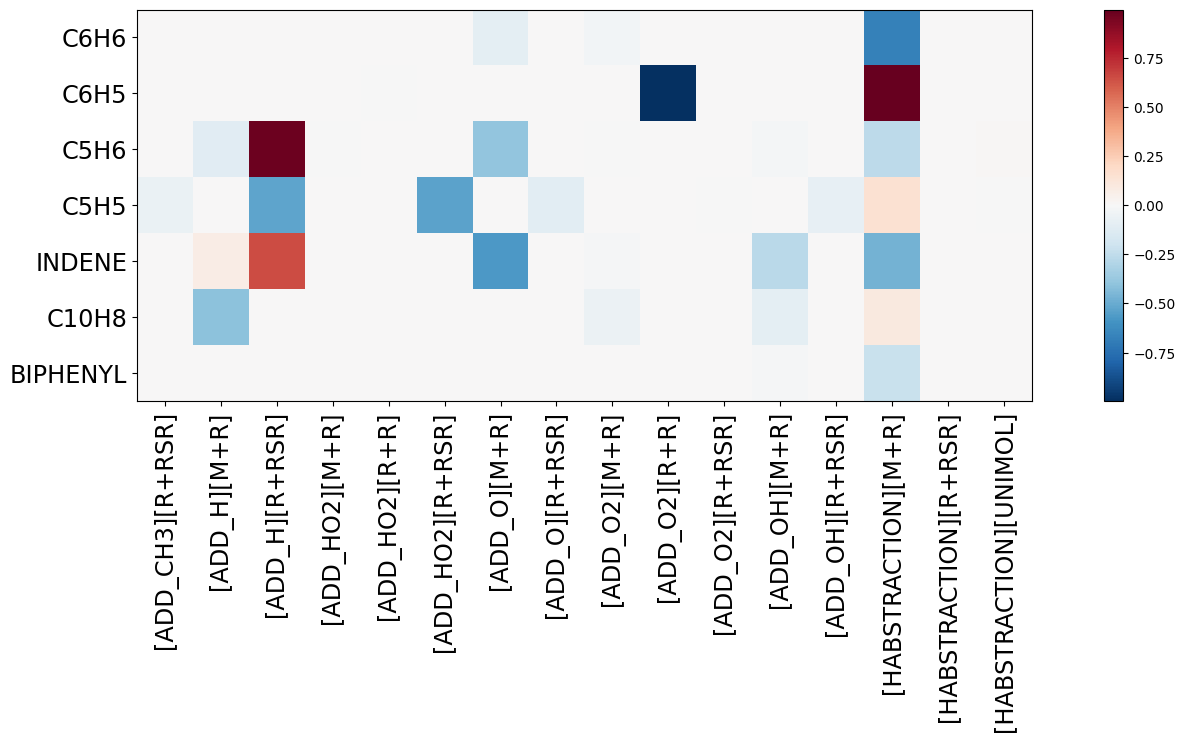

In [17]:
# additional type of classification: filter addition and abstraction reactions
species_list =['C6H6','C6H5','C5H6','C5H5','INDENE','C10H8','BIPHENYL']
filter_dct = {'classtype':['ADD', 'HABS']} # filter according to selected criteria in name
# thresh = 1e-3 # threshold for minimum flux
sortlist = ['classtype','bimoltype'] # classtype, speciestype, subclass, bimoltype (R+R, RSR+RSR, M+M, ETC) sum if both apply and sort by this criteria
    
for simul_name, simul_fld in simul_flds.items():
    pp = PostProcessor(kin_xml_fld, simul_fld)
    # assign class
    fluxbyclass = FluxByClass(pp.km, class_groups_fld)

    # ROPA for each species - if species_list contains dictionary, extract flux for each
    if isinstance(species_list[0], dict):
        flat_species_list = sum([list(d.values())[0] for d in species_list], [])
    else:
        flat_species_list = species_list
        
    tot_rop_dct = dict.fromkeys(flat_species_list)
    for sp in flat_species_list:
        tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                    ropa_type='global',
                                                    number_of_reactions=100)
    # prima c'era fluxbyclass qua sopra
    fluxbyclass.process_flux(species_list, tot_rop_dct)

    # assign flux and process according to selected criteria
    sortdf = fluxbyclass.sort_and_filter(sortlist, filter_dct = filter_dct)
    # plot heatmap
    fig = plot_heatmap(sortdf, symmetricaxis = True)
    # save heatmap
    save_fig(fig, plt_fld, sortlist, simul_name)

### Example 3 - flux analysis in a specific region/point by classtype:
do class analysis in a specific region or abscissa. What changes is essentially how the ropa_type is specified

C6H6 {'coefficients': [-2.1041811282390416e-05, -1.0665187866871548e-05, -3.3273517679172754e-06, -3.3273517679172754e-06, -2.227538359050667e-06, -1.8109138655884407e-06, -8.609137321426355e-07, 8.602678739348806e-07, -4.97204875601177e-07, 2.9810036886635865e-07, -2.5347978385491996e-07, 1.4689991482209045e-07, 1.1250851344070638e-07, -8.750857569484948e-08, -6.893578362437215e-08, -6.066080555956461e-08, -5.481998495496861e-08, 4.7744785226034033e-08, -4.541796857412313e-08, -4.2244601001780795e-08, -2.152840107982721e-08, -2.0780605044656367e-08, 1.988991914854632e-08, 1.7979531455121585e-08, -9.304094789552738e-09, 9.041602572551887e-09, -7.415022487592143e-09, -7.309331327329133e-09, -7.284261479748552e-09, -6.525337510073705e-09, 4.738428108161856e-09, 4.600245898093858e-09, 4.450953821380908e-09, 4.304331202617797e-09, 4.215156203050907e-09, 4.1954091431539714e-09, 4.191068180916962e-09, 3.753085047714204e-09, 3.488538535080441e-09, -3.305946608041448e-09, 3.240772006805907e-09

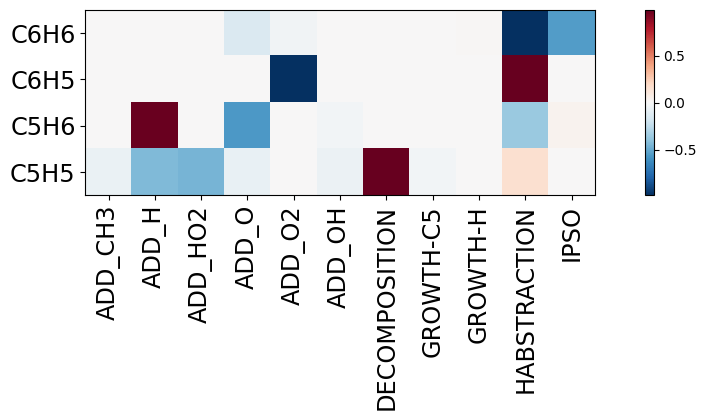

In [21]:
ropa_type = 'local'
local_value = 0.1
species_list =['C6H6','C6H5','C5H6','C5H5']
thresh = 1e-2     # threshold for minimum flux
n_of_rxns = 200   # max n of rxns to consider for flux (default: 100)
sortlist = ['classtype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']


pp = PostProcessor(kin_xml_fld, simul_fld)
# assign class
fluxbyclass = FluxByClass(pp.km, class_groups_fld)

# ROPA for each species - if species_list contains dictionary, extract flux for each
if isinstance(species_list[0], dict):
    flat_species_list = sum([list(d.values())[0] for d in species_list], [])
else:
    flat_species_list = species_list
    
tot_rop_dct = dict.fromkeys(flat_species_list)
for sp in flat_species_list:
    tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                ropa_type=ropa_type,
                                                local_value=local_value,
                                                number_of_reactions=n_of_rxns)
# prima c'era fluxbyclass qua sopra
fluxbyclass.process_flux(species_list, tot_rop_dct)

# assign flux and process according to selected criteria
sortdf = fluxbyclass.sort_and_filter(sortlist, thresh = thresh)
# plot heatmap
fig = plot_heatmap(sortdf, symmetricaxis = True)
# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-local')

C6H6 {'coefficients': [-1.9290191652238106e-05, -1.0548714643059636e-05, -3.291011311217864e-06, -3.291011311217864e-06, -2.2032137371118754e-06, -1.5451673024614399e-06, -9.654526441971163e-07, 4.098557469119969e-07, -3.215157216114531e-07, -2.5634818461341657e-07, -2.5071134464203753e-07, 9.177150659364491e-08, -7.656267577646129e-08, -7.542576696719924e-08, 6.685415464478285e-08, -6.248971276824296e-08, -4.805241685526728e-08, -4.736619354748084e-08, 3.4958841921166324e-08, -2.8591636331589244e-08, 2.424332894932361e-08, -1.8383410649847325e-08, 1.176596913976231e-08, -1.0056768928959877e-08, -8.514621477801871e-09, -7.175539384387372e-09, 6.69182659102879e-09, -5.7184377254902175e-09, -5.572079349122752e-09, 3.974861240874394e-09, 3.154170623958209e-09, 2.9500401812608373e-09, 2.697309039616005e-09, -2.148926700636492e-09, 2.0022357576660314e-09, 1.9358973013560893e-09, 1.6131814934114093e-09, 1.4511935515190363e-09, 1.2938689296253939e-09, -1.2791332179796655e-09, 1.2446065958823e

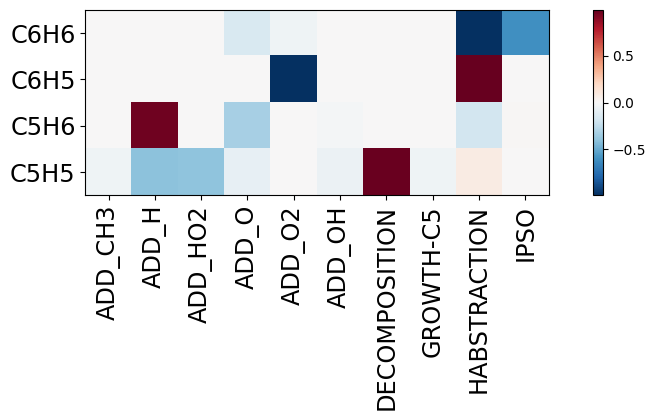

In [23]:
ropa_type = 'region'
lower_value = 0.01
upper_value = 0.1
species_list =['C6H6','C6H5','C5H6','C5H5']
thresh = 1e-2     # threshold for minimum flux
n_of_rxns = 200   # max n of rxns to consider for flux (default: 100)
sortlist = ['classtype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria

simul_fld = simul_flds['example-c6h6']


pp = PostProcessor(kin_xml_fld, simul_fld)
# assign class
fluxbyclass = FluxByClass(pp.km, class_groups_fld)

# ROPA for each species - if species_list contains dictionary, extract flux for each
if isinstance(species_list[0], dict):
    flat_species_list = sum([list(d.values())[0] for d in species_list], [])
else:
    flat_species_list = species_list
    
tot_rop_dct = dict.fromkeys(flat_species_list)
for sp in flat_species_list:
    tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                ropa_type=ropa_type,
                                                lower_value=lower_value,
                                                upper_value=upper_value,
                                                number_of_reactions=n_of_rxns)
# prima c'era fluxbyclass qua sopra
fluxbyclass.process_flux(species_list, tot_rop_dct)

# assign flux and process according to selected criteria
sortdf = fluxbyclass.sort_and_filter(sortlist, thresh = thresh)
# plot heatmap
fig = plot_heatmap(sortdf, symmetricaxis = True)
# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-region')

### Example 4 - flux analysis in a region by classtype on multiple species types:
region flux analysis as above, but group together the flux of C5, A1, A2
Then do the same but without weighing the flux for each species so that one is able to spot where the flux is larger

C6H6 {'coefficients': [-1.9290191652238106e-05, -1.0548714643059636e-05, -3.291011311217864e-06, -3.291011311217864e-06, -2.2032137371118754e-06, -1.5451673024614399e-06, -9.654526441971163e-07, 4.098557469119969e-07, -3.215157216114531e-07, -2.5634818461341657e-07, -2.5071134464203753e-07, 9.177150659364491e-08, -7.656267577646129e-08, -7.542576696719924e-08, 6.685415464478285e-08, -6.248971276824296e-08, -4.805241685526728e-08, -4.736619354748084e-08, 3.4958841921166324e-08, -2.8591636331589244e-08, 2.424332894932361e-08, -1.8383410649847325e-08, 1.176596913976231e-08, -1.0056768928959877e-08, -8.514621477801871e-09, -7.175539384387372e-09, 6.69182659102879e-09, -5.7184377254902175e-09, -5.572079349122752e-09, 3.974861240874394e-09, 3.154170623958209e-09, 2.9500401812608373e-09, 2.697309039616005e-09, -2.148926700636492e-09, 2.0022357576660314e-09, 1.9358973013560893e-09, 1.6131814934114093e-09, 1.4511935515190363e-09, 1.2938689296253939e-09, -1.2791332179796655e-09, 1.2446065958823e

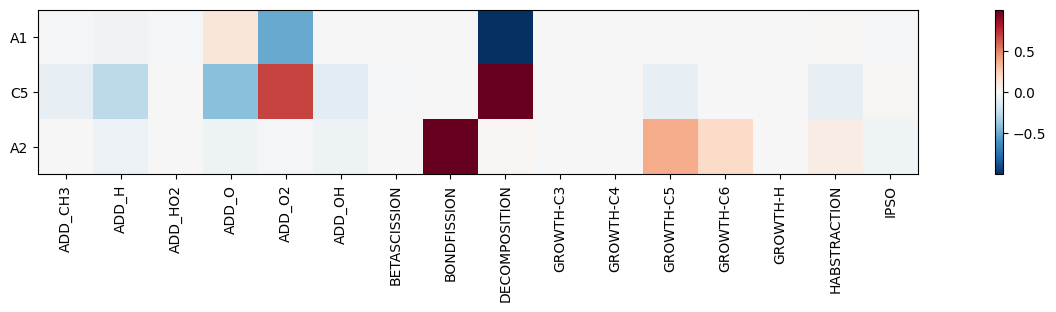

In [24]:
# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']}, {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlist = ['classtype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                         # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']

# ropa options
n_of_rxns = 200 #200   # max n of rxns to consider for flux (default: 10)
ropa_type = 'region'
lower_value = 0.01
upper_value = 0.1

# pp initialize
pp = PostProcessor(kin_xml_fld, simul_fld)
# assign class
fluxbyclass = FluxByClass(pp.km, class_groups_fld)
# ROPA for each species - if species_list contains dictionary, extract flux for each
if isinstance(species_list[0], dict):
    flat_species_list = sum([list(d.values())[0] for d in species_list], [])
else:
    flat_species_list = species_list
    
tot_rop_dct = dict.fromkeys(flat_species_list)
for sp in flat_species_list:
    tot_rop_dct[sp] = pp.RateOfProductionAnalysis(sp,
                                                    ropa_type,
                                                        lower_value=lower_value,
                                                        upper_value=upper_value,
                                                        number_of_reactions=n_of_rxns)

# assign flux and process according to selected criteria
fluxbyclass.process_flux(species_list, tot_rop_dct)
sortdf = fluxbyclass.sort_and_filter(sortlist)

# plot heatmap
fig = plot_heatmap(sortdf, symmetricaxis = True)

# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-region-sum')

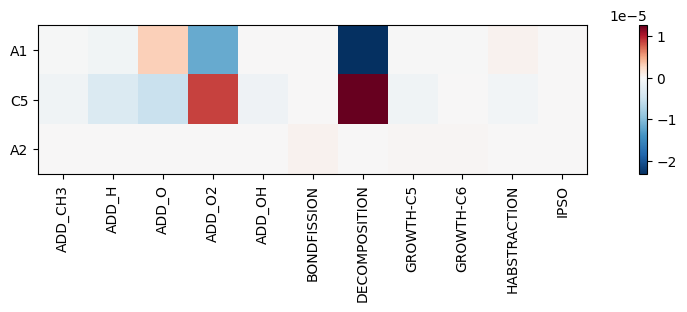

In [25]:
# do not weigh flux by species
# get the absolute flux - xes are asymmetric to accomodate for a larger scale when values span a larger range
sortdf = fluxbyclass.sort_and_filter(sortlist, thresh = 1e-2, weigheach = False)

# plot heatmap
fig = plot_heatmap(sortdf)

# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-region-sum-noweigh')